In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from ast import literal_eval
import datetime
import time  # for timing
import joblib # for saving objects
import random # for random number generation


TESTING = True
REGENERATE = False

if TESTING:
    dataset_name = 'netflix'
else:
    dataset_name = input("Enter dataset name: ")

# Search file with levinstein distance

dataset_files = []
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith(".csv"):
            dataset_files.append(file)


def calculate_levenshtein(str1, str2):
    replacementCost = [[]]

    for i in range(len(str1) + 1):
        replacementCost.append([])
        for j in range(len(str2) + 1):
            if i == 0:
                replacementCost[i].append(j)
            elif j == 0:
                replacementCost[i].append(i)
            elif str1[i - 1] == str2[j - 1]:
                replacementCost[i].append(replacementCost[i - 1][j - 1])
            else:
                replacementCost[i].append(1 + min(replacementCost[i - 1][j], replacementCost[i][j - 1],
                                                  replacementCost[i - 1][j - 1]))

    return replacementCost[len(str1)][len(str2)]


# Find the closest file
scores = []

for file in dataset_files:
    print(file)
    scores.append(calculate_levenshtein(dataset_name, file.split("_data")[0]))

closest_file_name = dataset_files[scores.index(min(scores))]
print("Closest file: " + closest_file_name)

# Load the dataset
df = pd.read_csv("data/" + closest_file_name)

df = df.drop(columns=["imdb_id"])

# print(df)
df["score_avg"] = (df["imdb_score"] + df["tmdb_score"]) / 2

hulu-tv_data.csv
disney-+_data.csv
amazon-prime_data.csv
rakuten-viki-tv_data.csv
netflix_data.csv
paramount-tv_data.csv
dark-matter-tv_data.csv
crunchyroll_data.csv
hbo-max_data.csv
Closest file: netflix_data.csv


In [255]:
class Progressbar:

    def __init__(self, maxValue, startTime=time.time()):
        self.startTime = startTime
        self.maxValue = maxValue

    def update(self, index):
        valueLength = len(str(self.maxValue))
        indexString = str(index)
        # while len(str(indexString)) < valueLength:
        #     indexString = " " + indexString

        indexString.rjust(valueLength - len(indexString))

        print("\rProgress: [{0:50s}] {1:.1f}%".format('#' * int((index + 1) * 50 / self.maxValue), (index + 1) * 100 / self.maxValue)
              + "    " + indexString + "/" + str(self.maxValue) + "    " +
              "Time left: {}".format(str(datetime.timedelta(seconds=(self.maxValue - (index + 1)) * (time.time() - self.startTime) / (index + 1)))), end="", flush=True)


In [256]:
unique_genres = []

for index, row in df.iterrows():
    row["genres"] = literal_eval(row["genres"])
    for genre in row["genres"]:
        if genre not in unique_genres:
            unique_genres.append(genre)

df["genres_index"] = df["genres"].apply(lambda x: [unique_genres.index(i) for i in literal_eval(x)])

print(unique_genres)


['documentation', 'crime', 'drama', 'comedy', 'fantasy', 'horror', 'european', 'thriller', 'action', 'music', 'romance', 'family', 'western', 'war', 'animation', 'history', 'scifi', 'reality', 'sport']


In [257]:
unique_production_countries = []

for index, row in df.iterrows():
    row["production_countries"] = literal_eval(row["production_countries"])
    for production_country in row["production_countries"]:
        if production_country not in unique_production_countries:
            unique_production_countries.append(production_country)

df["production_countries_index"] = df["production_countries"].apply(
    lambda x: [unique_production_countries.index(i) for i in literal_eval(x)])

print(unique_production_countries)


['US', 'GB', 'JP', 'EG', 'DE', 'IN', 'DZ', 'LB', 'FR', 'CA', 'SU', 'IT', 'HK', 'AR', 'KW', 'PE', 'BR', 'IE', 'GH', 'BF', 'ES', 'MX', 'AU', 'CO', 'BE', 'NO', 'PS', 'TR', 'BS', 'CZ', 'IS', 'DK', 'NZ', 'CN', 'KR', 'BG', 'RU', 'SG', 'MA', 'UY', 'TW', 'MY', 'CH', 'CL', 'NG', 'ZA', 'SA', 'AT', 'NL', 'SE', 'PH', 'Lebanon', 'TH', 'XX', 'AE', 'HU', 'ID', 'IL', 'FI', 'RO', 'CD', 'PL', 'VE', 'UA', 'IR', 'JO', 'QA', 'LU', 'BY', 'SK', 'HR', 'SY', 'GL', 'PT', 'PK', 'VN', 'PR', 'IQ', 'KH', 'GE', 'CU', 'KE', 'VA', 'RS', 'AL', 'TZ', 'TN', 'ZW', 'PY', 'NP', 'GR', 'CM', 'BD', 'KG', 'LT', 'CY', 'SN', 'MW', 'IO', 'MU', 'LK', 'AO', 'GT', 'MZ', 'AF', 'NA', 'FO']


In [258]:
unique_types = []

for index, row in df.iterrows():
    if row["type"] not in unique_types:
        unique_types.append(row["type"])

df["type_index"] = df["type"].apply(lambda x: unique_types.index(x))

print(unique_types)


['SHOW', 'MOVIE']


In [259]:
unique_age_certifications = []

for index, row in df.iterrows():
    if row["age_certification"] not in unique_age_certifications:
        unique_age_certifications.append(row["age_certification"])

df["age_certification_index"] = df["age_certification"].apply(
    lambda x: unique_age_certifications.index(x))

print(unique_age_certifications)

['TV-MA', 'R', 'PG', 'TV-14', 'G', 'PG-13', nan, 'TV-PG', 'TV-Y', 'TV-G', 'TV-Y7', 'NC-17']


In [260]:
df_splitted = pd.DataFrame(columns=df.columns)
df_splitted.drop(columns=["genres", "production_countries", "type", "age_certification"], inplace=True)

progressBar = Progressbar(len(df))

save_name = "saved/splitted_data_" + \
    dataset_name.split(".")[0].split("_")[0] + ".df"

if REGENERATE or not os.path.exists(save_name):
    for index, row in df.iterrows():

        progressBar.update(index)

        for genre_index in row["genres_index"]:
            row_copy = row.copy()
            row_copy["genres_index"] = genre_index

            for production_country_index in row_copy["production_countries_index"]:
                row_copy2 = row_copy.copy()
                row_copy2["production_countries_index"] = production_country_index        

                df_splitted.loc[len(df_splitted)] = row_copy2
            
    joblib.dump(df_splitted, save_name)
else:
    df_splitted = joblib.load(save_name)

df_splitted

,id,title,description,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,score_avg,genres_index,production_countries_index,type_index,age_certification_index
0,ts300399,Five Came Back: The Reference Films,This collection includes 12 World War II-era p...,1945,48,1.0,NaN,NaN,0.6,NaN,NaN,0,0,0,0
1,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,113,NaN,8.3,795222.0,27.612,8.2,8.25,1,0,1,1
2,tm84618,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,113,NaN,8.3,795222.0,27.612,8.2,8.25,2,0,1,1
3,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,NaN,8.2,530877.0,18.216,7.8,8.0,3,1,1,2
4,tm127384,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,NaN,8.2,530877.0,18.216,7.8,8.0,4,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,tm1014599,Fine Wine,A beautiful love story that can happen between...,2021,100,NaN,6.9,39.0,0.966,NaN,NaN,2,44,1,6
16846,tm1045018,Clash,A man from Nigeria returns to his family in Ca...,2021,88,NaN,6.5,32.0,0.709,NaN,NaN,11,44,1,6
16847,tm1045018,Clash,A man from Nigeria returns to his family in Ca...,2021,88,NaN,6.5,32.0,0.709,NaN,NaN,11,9,1,6
16848,tm1045018,Clash,A man from Nigeria returns to his family in Ca...,2021,88,NaN,6.5,32.0,0.709,NaN,NaN,2,44,1,6


In [261]:
# display the top 3 movies with the highest Imdb_score
df.sort_values(by=["imdb_score"], ascending=False, inplace=True)

# visualize the data
df.head(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,score_avg,genres_index,production_countries_index,type_index,age_certification_index
656,ts160526,Khawatir,SHOW,A TV show devoted to help young people to be m...,2005,TV-14,20,['reality'],[],11.0,9.6,3046.0,NaN,NaN,NaN,[17],[],0,3
2927,ts265844,#ABtalks,SHOW,#ABtalks is a YouTube interview show hosted by...,2018,TV-PG,68,[],[],1.0,9.6,7.0,NaN,NaN,NaN,[],[],0,7
243,ts4,Breaking Bad,SHOW,"When Walter White, a New Mexico chemistry teac...",2008,TV-MA,48,"['drama', 'thriller', 'crime']",['US'],5.0,9.5,1727694.0,337.419,8.8,9.15,"[2, 7, 1]",[0],0,0


## Scores by Type

[0] => SHOW
[1] => MOVIE


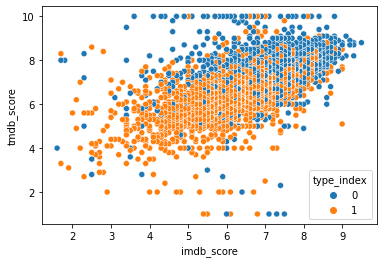

In [262]:
sns.scatterplot(x="imdb_score", y="tmdb_score", data=df, hue="type_index")

for index, value in enumerate(unique_types):
    print(f"[{index}] => {value}")

## Prediction

In [288]:
df_splitted_noNull= df_splitted.dropna() 

# Split in train and test set
X = df_splitted_noNull.drop(columns=['id', 'score_avg', 'title', 'description'])
y = df_splitted_noNull['score_avg']
y = y * 100 
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print(df_splitted_noNull[:1])

# generate new movie example with data  to predict
new_movie = X[:1].copy()

# generate new dummy data
new_movie["genres_index"] = 8
new_movie["production_countries_index"] = 0
new_movie["type_index"] = 1
new_movie["age_certification_index"] = 2
new_movie["release_year"] = 2004
new_movie["runtime"] = 120
new_movie["seasons"] = 1

model = DecisionTreeClassifier()
model.fit(X_train, y_train)



        id                         title  \
7  ts22164  Monty Python's Flying Circus   

                                         description release_year runtime  \
7  A British sketch comedy series with the shows ...         1969      30   

  seasons imdb_score imdb_votes tmdb_popularity tmdb_score score_avg  \
7     4.0        8.8    72895.0          12.919        8.3      8.55   

  genres_index production_countries_index type_index age_certification_index  
7            3                          1          0                       3  


DecisionTreeClassifier()

### Accuracy

In [291]:
print(new_movie)

predictions = model.predict(new_movie)
print(predictions / 100)

test_predictions = model.predict(X_test)

score = accuracy_score(y_test, test_predictions)
print(score)


   release_year  runtime  seasons imdb_score imdb_votes tmdb_popularity  \
7          2004      120        1        8.8    72895.0          12.919   

  tmdb_score  genres_index  production_countries_index  type_index  \
7        8.3             8                           0           0   

   age_certification_index  
7                        2  
[8.69]
0.9095149253731343
